In [1]:
%matplotlib inline
from numpy import *
import os
from os import listdir
from os.path import isfile, join
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from random import sample
from numpy import random
import scipy.io.wavfile
import sklearn
from sklearn.manifold import TSNE
import tensorflow as tf
import csv
#from skimage.transform import resize

In [2]:
n_classes = 3 # my classes (1000 # ImageNet)
net_in = zeros((1, 227,227,3)).astype(float32)
net_out = zeros((1, n_classes))
xdim = net_in.shape[1:]
ydim = net_out.shape[1]
net_data = load("fine_tuned_net2.npy").item()

In [3]:
def softmax(w):
    w = np.array(w)
    maxes = np.amax(w, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(w/maxes) # supposed to be minus maxes, but values were still too high
    dist = e / np.sum(e, axis=1)[:,None]
    return dist

def next_batch_not_rand(step,batch_size,files):    
    #files = sample(files, len(files))
    files = files[(step-1)*batch_size:step*batch_size]
    batch_x = np.ndarray([batch_size,227, 227, 3])
    batch_y = np.zeros((batch_size, 3))
    batch_names =[]
    i = 0
    for fname in files:
        img = (imread(join(ImgPath, fname))[:,:,:3]).astype(float32)
        #img = img - mean(img)
        #img = np.reshape(img,(1,227*227*3))        
        batch_x[i] = img
        if "cat" in fname:
            batch_y[i][0] = 1
        if "dog" in fname:
            batch_y[i][1] = 1
        if "flower" in fname:
            batch_y[i][2] = 1
        batch_names.append(fname)
        i+=1
    return batch_x, batch_y, batch_names

In [7]:
# (self.feed('data')
#         .conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
#         .lrn(2, 2e-05, 0.75, name='norm1')
#         .max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
#         .conv(5, 5, 256, 1, 1, group=2, name='conv2')
#         .lrn(2, 2e-05, 0.75, name='norm2')
#         .max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
#         .conv(3, 3, 384, 1, 1, name='conv3')
#         .conv(3, 3, 384, 1, 1, group=2, name='conv4')
#         .conv(3, 3, 256, 1, 1, group=2, name='conv5')
#         .fc(4096, name='fc6')
#         .fc(4096, name='fc7')
#         .fc(n_classes, relu=False, name='fc8')
#         .softmax(name='prob'))


def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    '''From https://github.com/ethereon/caffe-tensorflow
    '''
    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)   
    
    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups = tf.split(3, group, input)
        kernel_groups = tf.split(3, group, kernel)
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(3, output_groups)
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])


# Create model
def conv_net(x, weights, biases, dropout):
    
    x = x-tf.reduce_mean(x)
    
    #conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
    k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
    conv1_in = conv(x, weights['conv1W'], biases['conv1b'], k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
    conv1 = tf.nn.relu(conv1_in)

    #lrn(2, 2e-05, 0.75, name='norm1')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn1 = tf.nn.local_response_normalization(conv1, depth_radius=radius, alpha=alpha, beta=beta, bias=bias)

    #max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)
    
    #conv(5, 5, 256, 1, 1, group=2, name='conv2')
    k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv2_in = conv(maxpool1, weights['conv2W'], biases['conv2b'], k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv2 = tf.nn.relu(conv2_in)
    
    #lrn(2, 2e-05, 0.75, name='norm2')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn2 = tf.nn.local_response_normalization(conv2, depth_radius=radius, alpha=alpha, beta=beta, bias=bias)
    
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    #conv(3, 3, 384, 1, 1, name='conv3')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
    conv3_in = conv(maxpool2, weights['conv3W'], biases['conv3b'], k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv3 = tf.nn.relu(conv3_in)
    
    #conv(3, 3, 384, 1, 1, group=2, name='conv4')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
    conv4_in = conv(conv3, weights['conv4W'], biases['conv4b'], k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv4 = tf.nn.relu(conv4_in)
    
    #conv(3, 3, 256, 1, 1, group=2, name='conv5')
    k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv5_in = conv(conv4, weights['conv5W'], biases['conv5b'], k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv5 = tf.nn.relu(conv5_in)
    
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)
    
    #fc(4096, name='fc6')
    fc6 = tf.nn.relu_layer(tf.reshape(maxpool5, [-1, int(prod(maxpool5.get_shape()[1:]))]), weights['fc6W'], biases['fc6B'])
    fc6 = tf.nn.dropout(fc6, dropout)
    
    #fc(4096, name='fc7')
    fc7 = tf.nn.relu_layer(fc6, weights['fc7W'], biases['fc7B'])
    fc7 = tf.nn.dropout(fc7, dropout)
    
    #fc(n_classes, relu=False, name='fc8')
    fc8 = tf.nn.xw_plus_b(fc7, weights['fc8W'], biases['fc8B'])
    
    return fc8

def getFeat(x):
    return prob(x,weights,biases)

In [5]:
# Store layers weight & bias
weights = {    
    'conv1W': tf.Variable(net_data["conv1"][0], name="c1w"),
    'conv2W': tf.Variable(net_data["conv2"][0], name="c2w"),
    'conv3W': tf.Variable(net_data["conv3"][0], name="c3w"),
    'conv4W': tf.Variable(net_data["conv4"][0], name="c4w"),
    'conv5W': tf.Variable(net_data["conv5"][0], name="c5w"),
    'fc6W': tf.Variable(net_data["fc6"][0], name="fc6w"),
    'fc7W': tf.Variable(net_data["fc7"][0], name="fc7w"),
    'fc8W': tf.Variable(net_data["fc8"][0], name="fc8w")
}

biases = {    
    'conv1b': tf.Variable(net_data["conv1"][1], name="c1b"),
    'conv2b': tf.Variable(net_data["conv2"][1], name="c2b"),
    'conv3b': tf.Variable(net_data["conv3"][1], name="c3b"),
    'conv4b': tf.Variable(net_data["conv4"][1], name="c4b"),
    'conv5b': tf.Variable(net_data["conv5"][1], name="c5b"),
    'fc6B': tf.Variable(net_data["fc6"][1], name="fc6b"),
    'fc7B': tf.Variable(net_data["fc7"][1], name="fc7b"),
    'fc8B': tf.Variable(net_data["fc8"][1], name="fc8b")
}

In [8]:
x = tf.placeholder(tf.float32, (None,) + xdim) # None = number of input images
y = tf.placeholder(tf.float32, [None,ydim])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

# Construct model
prob = conv_net(x, weights, biases, keep_prob)
feat = tf.nn.softmax(prob) # subtract max

correct_pred = tf.equal(tf.argmax(prob, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))      

In [9]:
def plot_with_labels(lowDWeights, labels, filename):
    assert lowDWeights.shape[0] >= len(labels), "More labels than weights"
    plt.figure(figsize=(20, 20))  #in inches
    for i, label in enumerate(labels):
        x, y = lowDWeights[i,:]
        plt.scatter(x, y,color=label)
#         plt.annotate(label,
#                  xy=(x, y),
#                  xytext=(5, 2),
#                  textcoords='offset points',
#                  ha='right',
#                  va='bottom')

    plt.savefig(filename)

In [10]:
def min_resize(img, size):
    # for t-SNE visualization. Taken from https://gist.github.com/lukemetz/be6123c7ee3b366e333a
    """
    Resize an image so that it is size along the minimum spatial dimension.
    """
    w, h = map(float, img.shape[:2])
    if min([w, h]) != size:
        if w <= h:
            img = imresize(img, (int(round((h/w)*size)), int(size)))
        else:
            img = imresize(img, (int(size), int(round((w/h)*size))))
    return img

In [40]:
def scatter_images(lowDWeights,labels,images,img_res, output_filename,res=4000, cval=1*256.):
        # for t-SNE visualization. Modified from https://gist.github.com/lukemetz/be6123c7ee3b366e333a

    images = [min_resize(image, img_res) for image in images]
    max_width = max([image.shape[0] for image in images])
    max_height = max([image.shape[1] for image in images])
    
    xx = lowDWeights[:,0]
    yy = lowDWeights[:,1]
    x_min, x_max = xx.min(), xx.max()
    y_min, y_max = yy.min(), yy.max()
    # Fix the ratios
    sx = (x_max-x_min)
    sy = (y_max-y_min)
    if sx > sy:
        res_x = sx/float(sy)*res
        res_y = res
    else:
        res_x = res
        res_y = sy/float(sx)*res
    
    canvas = np.ones((res_x+max_width, res_y+max_height, 3))*cval
    x_coords = np.linspace(x_min, x_max, res_x)
    y_coords = np.linspace(y_min, y_max, res_y)
    for x, y, image, label in zip(xx, yy, images,labels):              
        w, h = image.shape[:2]
        x_idx = np.argmin((x - x_coords)**2)
        y_idx = np.argmin((y - y_coords)**2)
        canvas[x_idx:x_idx+w, y_idx:y_idx+h,:] = image.astype(uint8)
        canvas[x_idx, y_idx:y_idx+h] = label*255
        canvas[x_idx+w, y_idx:y_idx+h] = label*255
        canvas[x_idx:x_idx+w, y_idx] = label*255
        canvas[x_idx:x_idx+w, y_idx+h] = label*255

    plt.figure(figsize=(20, 20))  #in inches 
    plt.imshow(canvas.astype(uint8))
    plt.savefig(output_filename)
    return canvas

In [ ]:
# Classify
batch_size = 25
ImgPath = "/ImgDir/"
files = [f for f in listdir(ImgPath) if isfile(join(ImgPath, f))]
iters = len(files)
init = tf.initialize_all_variables()
labels = []
images = []
names = []
result = []
test_acc = []
with tf.Session() as sess:
    sess.run(init)
    step = 1        
    while step * batch_size < iters:    
        batch_x, batch_y, batch_names = next_batch_not_rand(step,batch_size,files)        
        images.extend(batch_x)
        labels.extend(batch_y)
        result.extend(sess.run(prob, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.}))
        names.extend(batch_names)
        test_acc.append(sess.run(accuracy, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.}))
        #print test_acc
        step += 1
    print "Test accuracy =  " + "{:.2f}%".format(np.mean(test_acc)*100)
    result_softmax = softmax(result)

Now calculating tSNE


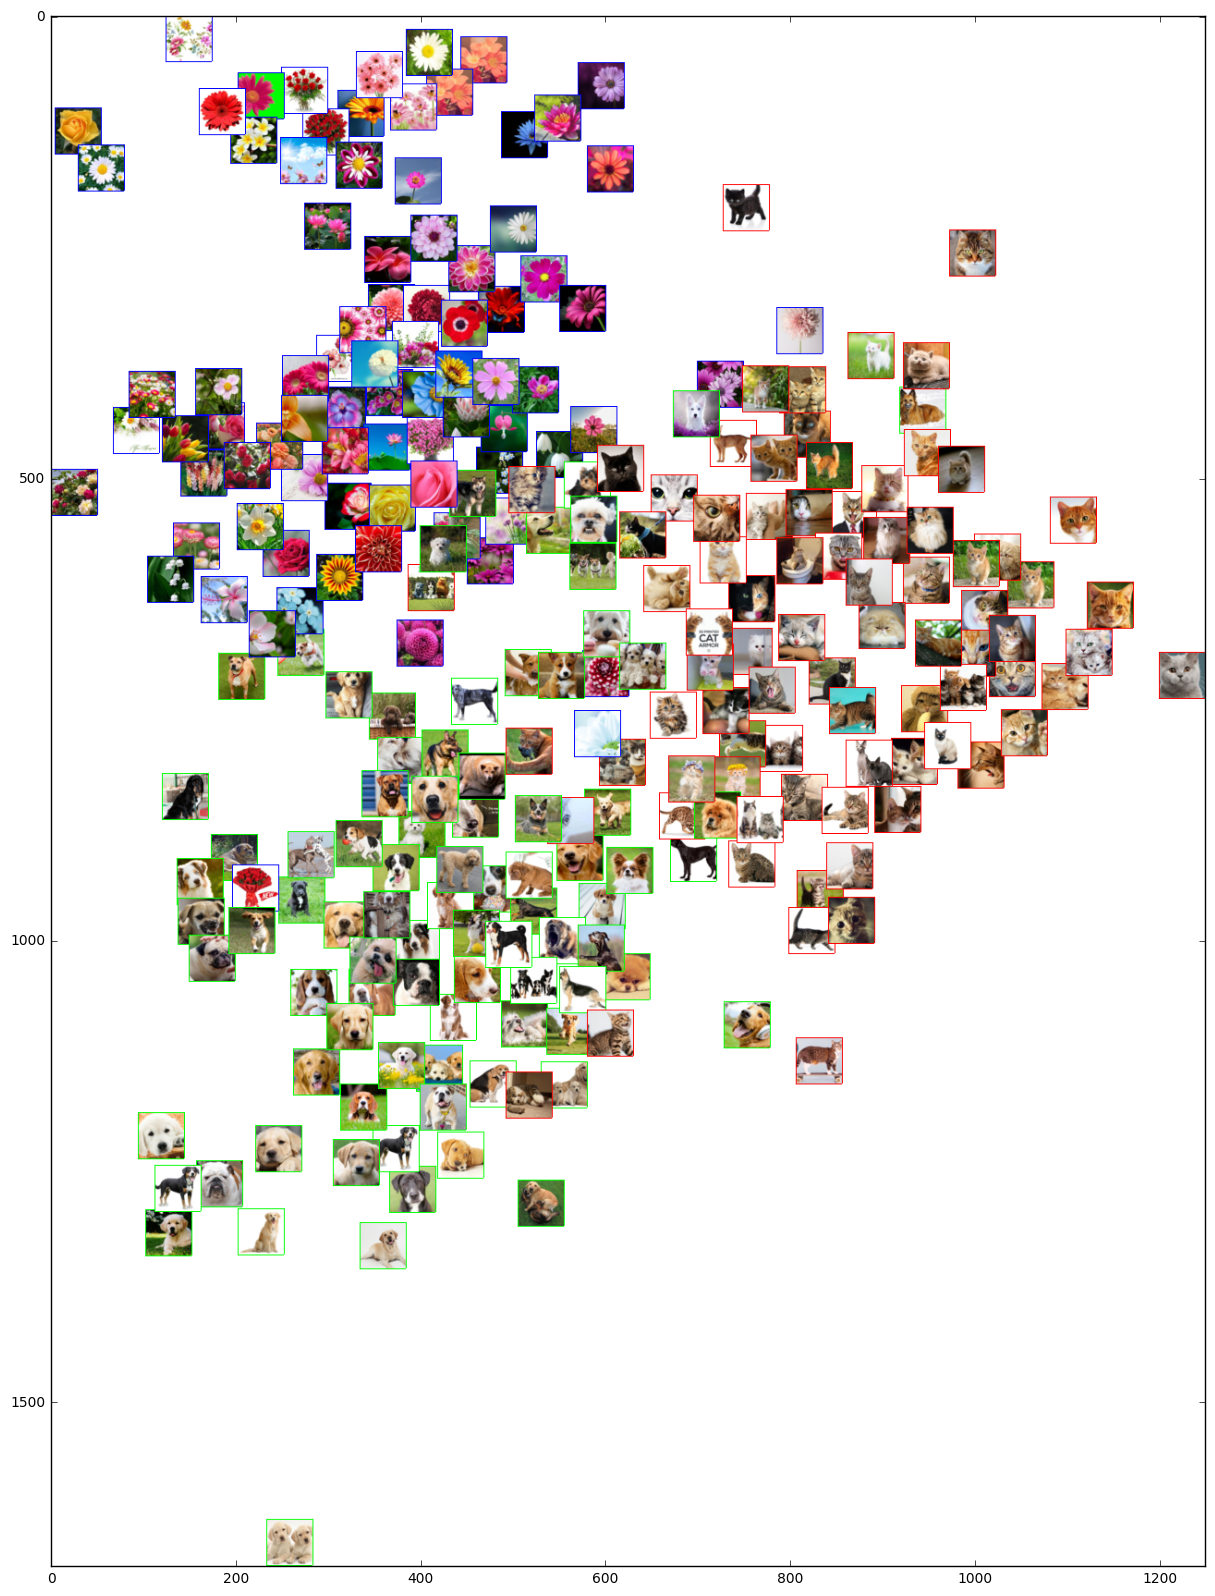

In [43]:
print "Now calculating tSNE"  

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)    
lowDWeights = tsne.fit_transform(result)    

output_filename = 'tsne_plots/tsne'+str(iters*100)+'_images.png'
img_res = 50
canvas = scatter_images(lowDWeights,labels,images,img_res,output_filename,res=1200, cval=1.*255)
plt.imshow(canvas.astype(uint8))
plt.show()